# CSIM 2019 - Cognitive Systems: Theory and Models
### Mila Sevilla Zhou, Paul Hine, Natasha Tylosky 
### ---------------

# Workcelona
## Predicting population movement from unemployment rates



In this notebook we will try to demonstrate that population movement is correllated to unemployment rates

For this project we are comparing unemployment to emigration and immigration in Barcelona.
Our hypothesis is that as unemployment rises emigration rises and as unemployment drop 
immigrantion rises. 

This means that we need to seperate out emigration and immigration into 2 seperate data sets.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.ndimage.interpolation import shift
import csv
import pandas as pd
!pip install scipy
import scipy
from scipy.stats import pearsonr 
from sklearn import linear_model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
data_path = '/content/gdrive/My Drive/CogSys_Final_Project/data/'

In [0]:
df_population = pd.read_csv(data_path+'bcn_population.csv', index_col=0)
df_unemployment = pd.read_csv(data_path+'bcn_unemployment.csv', index_col=0)
df_cpi = pd.read_csv(data_path+'bcn_cpi.csv', index_col=0)
df_gdp = pd.read_csv(data_path+'Spain_GPD_in_USD.csv', index_col=0)

## Pearson Correlations

In [0]:
# Pearson R Correlation

Y = df_population

## Unemployment
X_unemployment = df_unemployment
pearson_unemployment = pearsonr(X_unemployment['Unemployment'], Y['Population']) 
print("Pearson Unemployment", pearson_unemployment)  # Outputs coefficent and p-value

## CPI
X_cpi = df_cpi
pearson_cpi = pearsonr(X_cpi['CPI'], Y['Population']) 
print("Pearson CPI", pearson_cpi) 

## GDP
X_gdp = df_gdp
pearson_gdp = pearsonr(X_gdp['GDP'], Y['Population']) 
print("Pearson GDP", pearson_gdp) 

Pearson Unemployment (0.5846674898789607, 0.013701381417034069)
Pearson CPI (0.9525891750501257, 3.748400269450358e-09)
Pearson GDP (-0.16214742079460026, 0.5340969284772012)


## **Merge Datasets from 2001-2019**
First we need to merge the unemployment dataset.

In [0]:
#merge the datasets here using Concatenate pandas, pd.concat
df = pd.concat([df_population, df_cpi, df_unemployment, df_gdp], axis=1, join='outer')
print(df)

      Population    CPI  Unemployment          GDP
Year                                              
2002     4840919   72.3          10.8  17019.53541
2003     4956663   74.9          10.9  21495.70741
2004     5041008   77.6          10.4  24918.64584
2005     5127227   80.7           6.9  24918.64584
2006     5212783   83.7           6.5  28482.60948
2007     5294659   86.2           6.5  32709.40104
2008     5376590   89.7           8.6  35579.30993
2009     5452609   90.1          16.2  32334.00548
2010     5481511   92.0          17.7  30736.62785
2011     5508232   94.9          19.1  31835.28880
2012     5519370   97.7          22.5  28563.85904
2013     5492356   99.6          23.1  29211.77375
2014     5462583   99.8          20.0  29623.16445
2015     5463907   99.8          18.2  25789.51955
2016     5489294  100.0          15.5  26616.75780
2017     5533459  102.1          13.1  28156.81584
2018     5571822  104.0          11.1  32559.30000


### Plot our immigration/emigration

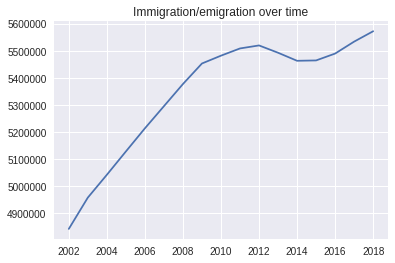

In [0]:
plt.title('Immigration/emigration over time')
plt.plot(df.index.values, df["Population"])
plt.show()

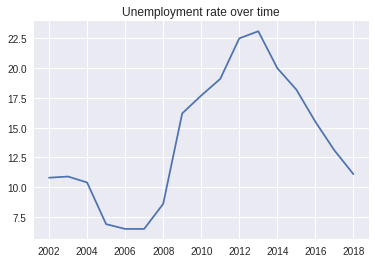

In [0]:
plt.title('Unemployment rate over time')
plt.plot(df.index.values, df["Unemployment"])
plt.show()


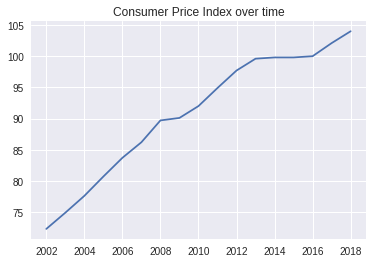

In [0]:
plt.title('Consumer Price Index over time')
plt.plot(df.index.values, df["CPI"])
plt.show()

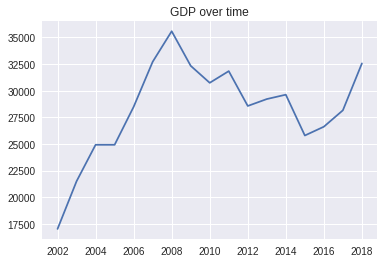

In [0]:
plt.title('GDP over time')
plt.plot(df.index.values, df["GDP"])
plt.show()

### Multiple Regression with Sklearn

In [0]:
def LinearRegression(offset, count, cols):
  Xdf = df[cols]
  X = Xdf.values
  Y = df["Population"].values
  I = df.index.values.reshape(-1,1)

  if offset != 0:
    Y = shift(Y, offset, cval=0)
  if (offset < 0):
    Y = Y[:offset]
    X = X[:offset,:]
    I = I[:offset]
  elif (offset > 0):
    Y = Y[offset:]
    X = X[offset:]
    I = I[offset:]
 
  Y = Y.reshape(-1,1)
   
  #merge X and Y
  XY = np.hstack((X,Y)) 
  IXY = np.hstack((I, XY))
  
  ## percentage of data to use for validation
  percentage_validation = .2 
  split = int(len(X)*percentage_validation)
  
  #store scores in an array
  scores = [] 
  coefs = [[] for i in cols]
  
  for i in range(count):
    #Randomly shuffle the data
    np.random.shuffle(IXY) 

    X = IXY[:,1:len(cols)+1]
    Y = IXY[:,len(cols)+1]
    I = IXY[:,0]  

    # Normalize
    X = (X-np.mean(X,0))/np.std(X,0)
    Y = (Y-np.mean(Y,0))/np.std(Y,0)

    #Split the data
    X_tr = X[:-split]
    Y_tr = Y[:-split]

    I_tr = I[:-split]
    I_vl = I[-split:]

    X_vl = X[-split:]
    Y_vl = Y[-split:]

    #Fit the model
    lm = linear_model.LinearRegression()
    model = lm.fit(X_tr,Y_tr)
    score = lm.score(X_vl,Y_vl)
#     print("{} | {} {} {}".format(I_tr, I_vl, score, lm.coef_))

    scores.append(score)
    for i in range(len(cols)):
      coefs[i].append(lm.coef_[i])
      
#     print(coefs)
  
  return (scores, coefs)
    


In [0]:
cols = ["Unemployment", "CPI", "GDP"]
(scores, coefs) = LinearRegression(0, 200, cols) #Run the linear regression 200 times


<function matplotlib.pyplot.show>

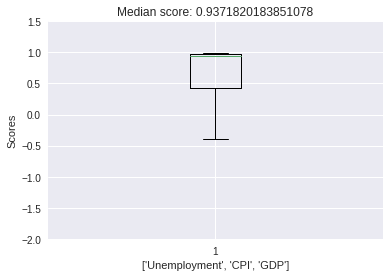

In [0]:
plt.title("Multi Regression Scores")
plt.title("Median score: {}".format(np.median(scores)))
plt.ylabel("Scores")
plt.xlabel(cols)
plt.boxplot(scores)
plt.ylim(bottom=-2, top=1.5)
plt.show

<function matplotlib.pyplot.show>

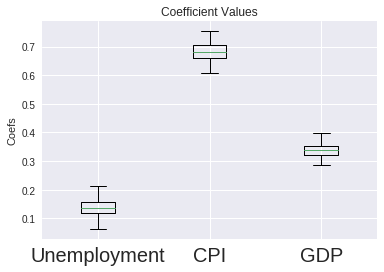

In [0]:
plt.title("Coefficient Values")
plt.ylabel("Coefs")
plt.boxplot(coefs)
plt.xticks([1,2,3],cols,fontsize=20)
# plt.ylim(bottom=-2, top=1.5)
plt.show

### Cross-correlation
Try to find relationships by shifting a time offset between X and Y 

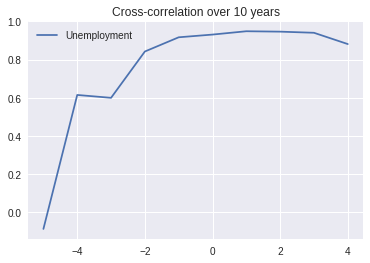

In [0]:
offsets = list(range(-5, 5))
regressions = []

for i in range(-5, 5):
  (scores, _) = LinearRegression(i, 200, cols)
  regressions.append(np.median(scores))
    
plt.title('Cross-correlation over 10 years')
plt.plot(offsets, regressions, label="Unemployment")
plt.legend()
